# Data pre-processing of enron email data for downstream analysis use
- This process unifies the email dataset compiled from multiple raw .txt files containing message metadata and body text. 
- It serves as the base dataset for all downstream analysis, prior to any text cleaning, NLP processing, or clustering.

- Input: individual .txt files representing emails and metadata
- Output: merged_df.pkl.gz

- Dataframe :
    - subject date	
    - date_short
    - message_id	
    - from_addr	
    - person_box	
    - sub_mailbox	
    - sub_mailbox2	
    - email_body

## 1. Data Extraction from txt files

In [ ]:
import tarfile
import os

archive_path = '..\data\enron_mail_20150507.tar.gz'
destination_path = '..\data\extracted_data'


# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Open the tar.gz file and extract all its contents
with tarfile.open(archive_path, 'r:gz') as tar:
    tar.extractall(path=destination_path)

print(f"All files from '{archive_path}' extracted to '{destination_path}'")



All files from '..\data\enron_mail_20150507.tar.gz' extracted to '4_enron_mail_nlp\data\extracted_data'


## 2. Loading Data into dataframe

  1. Read individual email files from each mail box
  2. Put into a dataframe, dedup and tag mailbox source 

### Function for parsing email

In [ ]:
import pandas as pd
import email
from email import policy
import os
import glob
import io
import chardet

# Function to parse a single email file and extract relevant data
def parse_email_file(file_path):
    """
    Parses an email file and returns a dictionary with extracted information.
    """

    sub_mailbox = file_path.split(os.sep)[5]
    if os.path.isfile(file_path)==False:
        sub_mailbox2 = file_path.split(os.sep)[6:]
    else:
        sub_mailbox2 = ''


    try:
        # Detect the file's encoding first
        with open(file_path, 'rb') as raw_file:
            raw_data = raw_file.read()
            detected_encoding = chardet.detect(raw_data)['encoding']


        with open(file_path, 'r', encoding=detected_encoding, errors='replace') as email_file:
            content = email_file.read()#email.message_from_file(email_file, policy=policy.default)
            content = io.StringIO(content)
            msg = email.message_from_file(content, policy=policy.default)
            
            message_id = msg['Message-ID']
            date = msg['Date']
            subject = msg['Subject']
            to_addr = msg['To']
            from_addr = msg['From']
            person_box = msg['X-Origin']
            
            # Handle both plain text and multipart emails for the body
            if msg.is_multipart():
                body = ""
                for part in msg.walk():
                    if part.get_content_type() == "text/plain":
                        body = part.get_payload(decode=True).decode(errors='ignore')
                        break
            else:
                body = msg.get_payload(decode=True).decode(errors='ignore')
            
            email_body = body.strip()

            return {
                'subject': subject,
                'date': date,
                'date_short': date[:17],
                'message_id': message_id,
                'from_addr': from_addr,
                'to_addr': to_addr,
                'person_box': person_box,
                'sub_mailbox': sub_mailbox,
                'sub_mailbox2': "\\".join(sub_mailbox2),
                'email_body': email_body
            }
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None



### Function for recursively reading files from mail directory 

In [ ]:
import os


def read_files_recursively(root_dir,all_email_data):
    """
    Recursively reads all files within a given directory and its subdirectories.

    Args:
        root_dir (str): The path to the starting directory.
    """

    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # dirpath is the current directory being traversed
        # dirnames is a list of subdirectories in dirpath
        # filenames is a list of files in dirpath

        # print(f"Processing directory: {dirpath}")
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            try:
                
                if os.path.isfile(file_path):
                    email_data = parse_email_file(file_path)
                if email_data:
                    all_email_data.append(email_data)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    return all_email_data



### Crawl all directories and sub-directories and save to a dataframe

In [7]:
# Example usage:
# Replace 'your_directory_path' with the actual path you want to traverse
all_email_data=[]

# Feed all mail data
read_files_recursively('..\data\extracted_data\maildir',all_email_data )


df_all = pd.DataFrame(all_email_data)

# Print the resulting DataFrame
df_all['date_short']  = pd.to_datetime(df_all['date_short'])
df_all.head(5)

Error processing file ..\data\extracted_data\maildir\kitchen-l\sent_items\24: 'ValueTerminal' object does not support item assignment
Error processing file ..\data\extracted_data\maildir\kitchen-l\_americas\esvl\87: 'ValueTerminal' object does not support item assignment
Error processing file ..\data\extracted_data\maildir\kitchen-l\_americas\netco_eol\82: 'ValueTerminal' object does not support item assignment
Error processing file ..\data\extracted_data\maildir\kitchen-l\_americas\netco_eol\83: 'ValueTerminal' object does not support item assignment
Error processing file ..\data\extracted_data\maildir\kitchen-l\_americas\netco_restart\3: 'ValueTerminal' object does not support item assignment


,subject,date,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body
0,"December 14, 2000 - Bear Stearns' predictions ...","Wed, 13 Dec 2000 18:41:00 -0800",2000-12-13,<29790972.1075855665306.JavaMail.evans@thyme>,1.11913372.-2@multexinvestornetwork.com,Allen-P,all_documents,,In today's Daily Update you'll find free repor...
1,Bloomberg Power Lines Report,"Wed, 13 Dec 2000 08:35:00 -0800",2000-12-13,<21975671.1075855665520.JavaMail.evans@thyme>,messenger@ecm.bloomberg.com,Allen-P,all_documents,,Here is today's copy of Bloomberg Power Lines....
2,Consolidated positions: Issues & To Do list,"Mon, 09 Oct 2000 07:16:00 -0700",2000-10-09,<7452188.1075855667684.JavaMail.evans@thyme>,phillip.allen@enron.com,Allen-P,all_documents,,---------------------- Forwarded by Phillip K ...
3,Consolidated positions: Issues & To Do list,"Mon, 09 Oct 2000 07:00:00 -0700",2000-10-09,<23790115.1075855667708.JavaMail.evans@thyme>,phillip.allen@enron.com,Allen-P,all_documents,,---------------------- Forwarded by Phillip K ...
4,,"Thu, 05 Oct 2000 06:26:00 -0700",2000-10-05,<5860470.1075855667730.JavaMail.evans@thyme>,phillip.allen@enron.com,Allen-P,all_documents,,"Dave, \n\n Here are the names of the west desk..."


## 3. Checks and Finalizing UNCLEANED DATASET

  1.  Converted date_short to datetime and dropped old date column
  2.  Removed duplicate emails in df_deleted (deleted_items) and df_rest (others)
  3. Identified emails present in both deleted and non-deleted sets
  4. Merged both datasets into merged_df
  5. Counted emails per sub_mailbox and checked top categories
  6. Reviewed descriptive statistics of the merged dataset
  7. Saved merged_df as a compressed pickle file for reuse

In [8]:
# df_deleted = df_deleted.drop_duplicates(subset=['message_id'], keep='first')
df_all['date_short']  = pd.to_datetime(df_all['date_short'])
df_all = df_all.drop(columns=['date'])
df_all.describe(include='all')

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body
count,517396,517396,517396,517396,517367,517396,517396,517396
unique,159287,NaN,517396,20326,259,1427,1,247871
top,,NaN,<29790972.1075855665306.JavaMail.evans@thyme>,kay.mann@enron.com,Kaminski-V,all_documents,,"As you know, Enron Net Works (ENW) and Enron G..."
freq,19187,NaN,1,16735,26995,128103,517396,112
mean,NaN,2001-02-18 23:33:46.452465920,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1979-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2000-10-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2001-03-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2001-08-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2044-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_deleted = df_all[df_all['sub_mailbox']=='deleted_items']
df_deleted = df_deleted.drop_duplicates(subset=['message_id'], keep='first')
df_deleted.describe(include='all')

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body
count,51356,51356,51356,51356,51352,51356,51356,51356
unique,27386,NaN,51356,8961,203,1,1,41194
top,RE:,NaN,<21543395.1075855374340.JavaMail.evans@thyme>,no.address@enron.com,Shapiro-R,deleted_items,,Enron in Action can be accessed through the ne...
freq,1914,NaN,1,2588,1488,51356,51356,82
mean,NaN,2001-11-14 01:05:19.931458816,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1986-04-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2001-10-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2001-11-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2002-01-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2024-05-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_rest = df_all[df_all['sub_mailbox']!='deleted_items']
df_rest = df_rest.drop_duplicates(subset=['message_id'], keep='first')
df_rest.describe(include='all')

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body
count,466040,466040,466040,466040,466015,466040,466040,466040
unique,141377,NaN,466040,15591,259,1426,1,214204
top,,NaN,<29790972.1075855665306.JavaMail.evans@thyme>,kay.mann@enron.com,Kaminski-V,all_documents,,Ken Lay and Jeff Skilling were interviewed on ...
freq,17915,NaN,1,16645,25894,128103,466040,107
mean,NaN,2001-01-20 10:36:37.943523840,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1979-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2000-09-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2001-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2001-05-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2044-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
common_df = pd.merge(df_rest, df_deleted, how='inner', on='message_id')
len(common_df)

0

In [ ]:
merged_df = pd.concat([df_rest, df_deleted], ignore_index=True, sort=False)
groupd = merged_df.groupby(['sub_mailbox']).size()
print(groupd.sort_values(ascending=False)[0:11])
# print(groupd)

sub_mailbox
all_documents         128103
discussion_threads     58609
sent                   57653
deleted_items          51356
inbox                  44859
sent_items             37920
notes_inbox            36665
_sent_mail             30109
calendar                6133
archiving               4477
_americas               4017
dtype: int64


In [13]:
merged_df.describe(include='all')

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body
count,517396,517396,517396,517396,517367,517396,517396,517396
unique,159287,NaN,517396,20326,259,1427,1,247871
top,,NaN,<29790972.1075855665306.JavaMail.evans@thyme>,kay.mann@enron.com,Kaminski-V,all_documents,,"As you know, Enron Net Works (ENW) and Enron G..."
freq,19187,NaN,1,16735,26995,128103,517396,112
mean,NaN,2001-02-18 23:33:46.452465408,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1979-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2000-10-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2001-03-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2001-08-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2044-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


### Pickling Organized dataframe for later use

In [34]:
merged_df.to_pickle('..\data\merged_df.pkl.gz', compression='gzip')

# Exploratory Data Analysis - Inspecting mailbox count

- There appear to be cleaning or deletion activities coinciding with the US government audit (around October 2001).
- No overlapping emails were found among the three sampled mailboxes. We should consider scraping all subfolders to expand the corpus.
- There is currently no evidence that the high email deletion rate was intended to hide documents. 
- Possible explanations include:
    - An unusually high email volume leading to more deletions - technical limitation rationale
    - Emails containing sensitive content - intent to conceal from government auditors

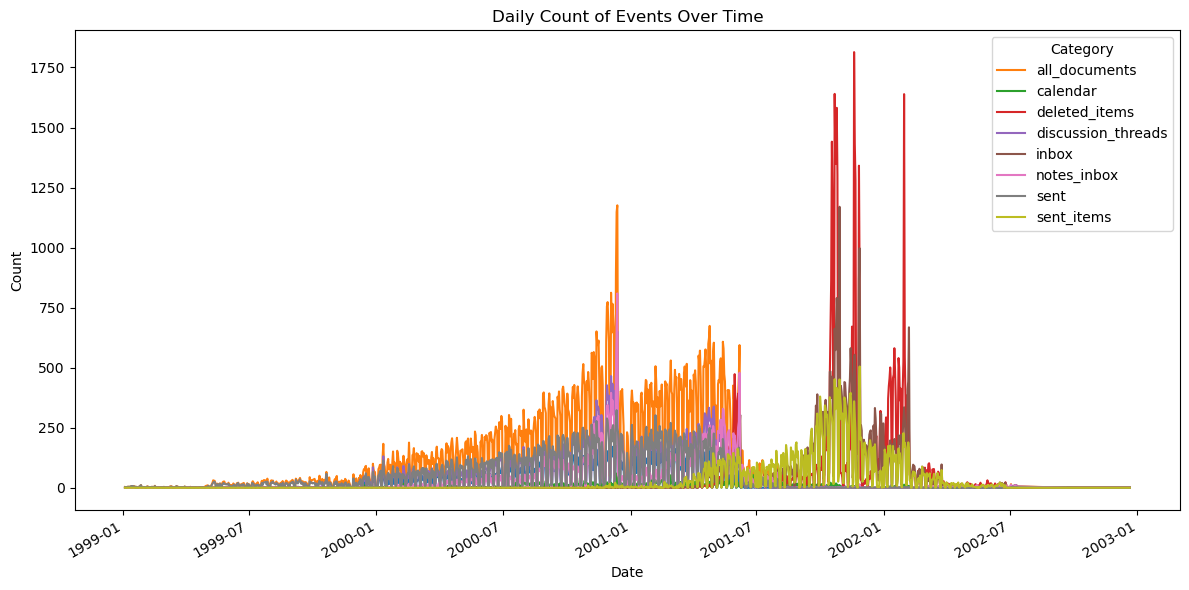

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filter top mailbox
mailboxes=['inbox', 'deleted_items', 'sent','sent_items', 'all_documents', 'calendar', '_sent_mail', 'notes_inbox', 'discussion_threads']

df_1999_2003 = merged_df[merged_df.date_short.dt.year.between(1999, 2003)]
df_1999_2003 = df_1999_2003[df_1999_2003['sub_mailbox'].isin(mailboxes)]
daily_counts = df_1999_2003.groupby(['date_short','sub_mailbox']).size().unstack(fill_value=0)


daily_counts

daily_counts.plot(
    kind='line',
    figsize=(12, 6),
    title='Daily Count of Events Over Time'
)

# Add labels for clarity
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

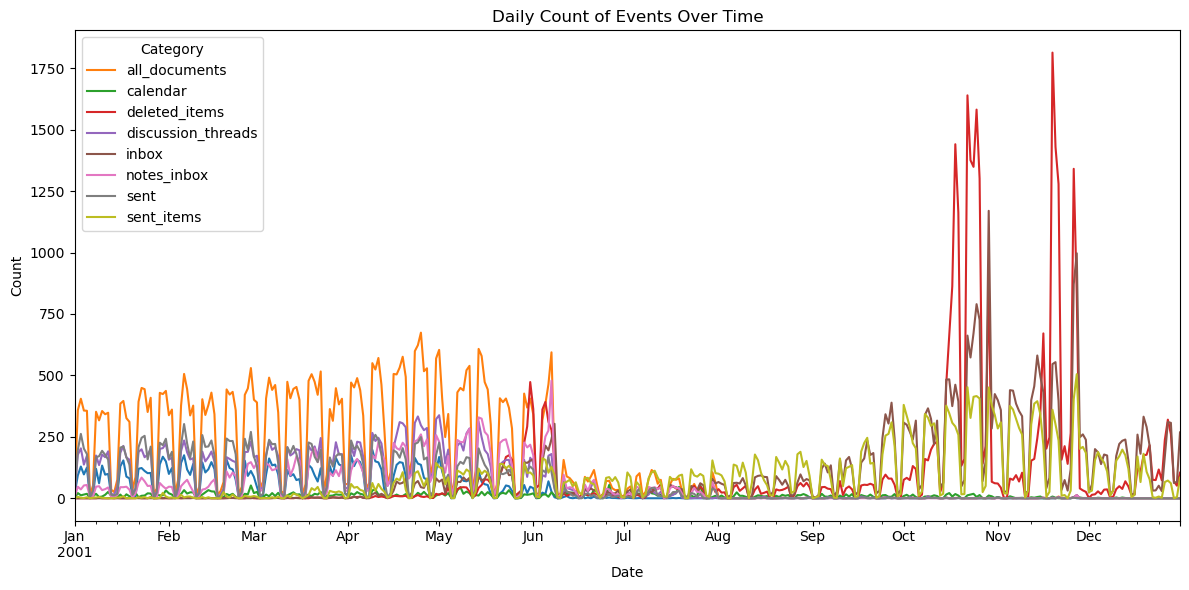

In [32]:
df_2001 = df_1999_2003[df_1999_2003.date_short.dt.year==2001]
daily_counts = df_2001.groupby(['date_short','sub_mailbox']).size().unstack(fill_value=0)


daily_counts

daily_counts.plot(
    kind='line',
    figsize=(12, 6),
    title='Daily Count of Events Over Time'
)

# Add labels for clarity
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

# Data pre-processing (Cleaning email for text analysis)
-This pipeline prepares email text for further analysis, like content extraction, NLP, or sentiment analysis, by keeping only the relevant and latest message content

- Input : merged_df.pkl.gz
- Output : df_clean_1999_pickled.pkl.gz , df_clean_2000_pickled.pkl.gz, df_clean_2001_pickled.pkl.gz , df_clean_2002_pickled.pkl.gz

- Dataframe :
    - subject date	
    - date_short
    - message_id	
    - from_addr	
    - person_box	
    - sub_mailbox	
    - sub_mailbox2	
    - email_body
    - cleaned_email_body    

Data Cleaning/Transformation done 
- Removed duplicate or repeated email headers (forwarded/original message markers).
- Standardized whitespace and removed unwanted characters (\n, \t, \).
- Extracted the latest email reply from threads containing multiple replies.
- Split blocks of text into individual emails using email addresses as separators.
- Stripped empty strings and excess whitespace to create clean, single-message text.

## 1. Building the function for cleaning of email text

In [1]:
import re
import pandas as pd
from itables import show



def clean_email_text(text):
    # 1. Split the text at the forwarded header line.
    #    The header starts with '----- Forwarded by...'.
    # 2. Keep only the first part, which contains the original message.

    parts = text.split('----- Forwarded by')
    cleaned_text = parts[0]

    cleaned_text = cleaned_text.split('----- Original Message')
    cleaned_text = cleaned_text[0]

    # 3. Clean up the remaining newlines, tabs, and backslashes.
    cleaned_text = cleaned_text.replace('\n', ' ')
    cleaned_text = cleaned_text.replace('\t', ' ')
    cleaned_text = cleaned_text.replace('\\', '') # Use \\ to match a literal backslash.

    # 4. Remove any extra whitespace created during cleaning.
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text


def extract_latest_reply_by_splitting(email_body):
    """
    Extracts the latest reply from an email thread using string splitting.

    Args:
        email_body (str): The full text of the email, including all replies.

    Returns:
        str: The latest reply, with whitespace and common separators removed.
    """
    # A list of common reply markers to look for, prioritized.
    common_separators = [
        # Outlook's standard reply separator.
        "-----Original Message-----",
        # A common separator for older emails or plain text replies.
        "---",
        # Generic reply header. This is less reliable.
        "From:",
        # The common "On [date]... wrote:" header.
        "wrote:",
        # Gmail and other web clients often use this for quoted text.
        ">",
    ]

    # Iterate through the list of separators and split the email body.
    for separator in common_separators:
        # Use a case-insensitive search to catch variations like "--Original Message--"
        if separator.lower() in email_body.lower():
            # Find the position of the first separator
            split_index = email_body.lower().find(separator.lower())
            # Return the text before the first separator, stripping excess whitespace.
            return email_body[:split_index].strip()
    
    # If no separators are found, assume the entire email is the latest reply.
    return email_body.strip()

def parse_emails_latest(email_text):
    """
    Parses a block of email text using a generic email signature pattern.
    The pattern assumes a signature is preceded by a newline.

    Args:
        email_text (str): A string containing multiple emails.

    Returns:
        list: A list of strings, where each string is an individual email message.
    """
    # This regex looks for a word or initial followed by an email address,
    # often found on a new line.
    # Pattern explanation:
    # r'\n' : A newline character.
    # r'[A-Z][a-z]+\s' : Matches a capitalized name (e.g., 'Eman ').
    # r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}' : A standard email address pattern.
    # email_pattern = r'\n.*?<?[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}>?.*\n'
    email_pattern =r'\n.*@.*\n'
    
    # Use re.split() to split the text. Using 're.MULTILINE' is crucial here,
    # as '^' and '$' will match the start and end of each line, not just the string.
    # We include the capturing group so that the separator is included in the output.
    # We also use re.IGNORECASE to match email addresses regardless of case.
    messages = re.split(email_pattern, email_text, flags=re.IGNORECASE)
    
    # Remove any empty strings that may result from the split and strip whitespace.
    return [msg.strip() for msg in messages if msg.strip()][0]




## 2. Load the dataframe that we performed earlier: merged_df.pkl.gz

In [6]:
merged_df_pick = pd.read_pickle('.\data\merged_df.pkl.gz', compression='gzip')

In [7]:
merged_df_pick.describe(include='all')

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body
count,517396,517396,517396,517396,517367,517396,517396,517396
unique,159287,NaN,517396,20326,259,1427,1,247871
top,,NaN,<29672819.1075842023959.JavaMail.evans@thyme>,kay.mann@enron.com,Kaminski-V,all_documents,,"As you know, Enron Net Works (ENW) and Enron G..."
freq,19187,NaN,1,16735,26995,128103,517396,112
mean,NaN,2001-02-18 23:33:46.452465408,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1979-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2000-10-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2001-03-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2001-08-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2044-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
merged_df_pick[merged_df_pick['sub_mailbox']=='deleted_items'].iloc[8000]

subject                                 ABX2 2 - Windfall Profits
date_short                                    2001-09-10 00:00:00
message_id          <31292353.1075852563433.JavaMail.evans@thyme>
from_addr                                     sgovenar@govadv.com
person_box                                             Shankman-J
sub_mailbox                                         deleted_items
sub_mailbox2                                                     
email_body      ABX2 2 (Corbett) was heard on the Assembly flo...
Name: 474040, dtype: object

## 3. Test the Cleaning Functions

In [9]:
# test #3002

test_rec=merged_df_pick.iloc[3002]

text=test_rec.email_body
subj=test_rec.subject


# text=merged_df_pick.iloc[300,-1]
print(subj)
print(text)
print("----------")
print("-----cleaned text-----")
print("----------")
print(clean_email_text(extract_latest_reply_by_splitting(parse_emails_latest(text))))





Re: requirement document
Looks good.  I'm a little confused as to how many users can be on.  The 
system needs to be able to handle 50+ users at one time, each being able to 
post messages any time.  




Brian Hoskins@ENRON COMMUNICATIONS
09/28/2000 02:31 PM
To: Fangming Zhu/Corp/Enron@ENRON
cc: Allen Elliott/HOU/ECT@ECT, John Arnold/HOU/ECT@ECT 
Subject: Re: requirement document   

Fangming,

Looks good.  That's exactly what we're looking for.  John, please comment if 
there are any additional features you'd like to add.

Brian


Brian T. Hoskins
Enron Broadband Services
713-853-0380 (office)
713-412-3667 (mobile)
713-646-5745 (fax)
Brian_Hoskins@enron.net





	Fangming Zhu@ENRON
	09/28/00 02:23 PM
		 
		 To: Brian Hoskins/Enron Communications@Enron Communications
		 cc: Allen Elliott/HOU/ECT@ECT
		 Subject: requirement document 

Hi, Brian:

Please review attached requirement document and reply this message with any 
comments. Once you approve it, I am going to build the applicati

## 4. Cleaning email body

In [10]:

merged_df_pick['cleaned_email_body'] = merged_df_pick['email_body'].apply(lambda x: clean_email_text(extract_latest_reply_by_splitting(parse_emails_latest(x))))

merged_df_pick.head(5)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body
0,"December 14, 2000 - Bear Stearns' predictions ...",2000-12-13,<29790972.1075855665306.JavaMail.evans@thyme>,1.11913372.-2@multexinvestornetwork.com,Allen-P,all_documents,,In today's Daily Update you'll find free repor...,In today's Daily Update you'll find free repor...
1,Bloomberg Power Lines Report,2000-12-13,<21975671.1075855665520.JavaMail.evans@thyme>,messenger@ecm.bloomberg.com,Allen-P,all_documents,,Here is today's copy of Bloomberg Power Lines....,Here is today's copy of Bloomberg Power Lines....
2,Consolidated positions: Issues & To Do list,2000-10-09,<7452188.1075855667684.JavaMail.evans@thyme>,phillip.allen@enron.com,Allen-P,all_documents,,---------------------- Forwarded by Phillip K ...,
3,Consolidated positions: Issues & To Do list,2000-10-09,<23790115.1075855667708.JavaMail.evans@thyme>,phillip.allen@enron.com,Allen-P,all_documents,,---------------------- Forwarded by Phillip K ...,
4,,2000-10-05,<5860470.1075855667730.JavaMail.evans@thyme>,phillip.allen@enron.com,Allen-P,all_documents,,"Dave, \n\n Here are the names of the west desk...","Dave, Here are the names of the west desk memb..."


## 5. Take out those emails that are blank after cleaning

In [11]:
merged_df_pick_cleaned = merged_df_pick[merged_df_pick['cleaned_email_body'].str.strip() != '']
# merged_df_pick_cleaned.describe(include='all')
merged_df_pick_cleaned.head(5)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body
0,"December 14, 2000 - Bear Stearns' predictions ...",2000-12-13,<29790972.1075855665306.JavaMail.evans@thyme>,1.11913372.-2@multexinvestornetwork.com,Allen-P,all_documents,,In today's Daily Update you'll find free repor...,In today's Daily Update you'll find free repor...
1,Bloomberg Power Lines Report,2000-12-13,<21975671.1075855665520.JavaMail.evans@thyme>,messenger@ecm.bloomberg.com,Allen-P,all_documents,,Here is today's copy of Bloomberg Power Lines....,Here is today's copy of Bloomberg Power Lines....
4,,2000-10-05,<5860470.1075855667730.JavaMail.evans@thyme>,phillip.allen@enron.com,Allen-P,all_documents,,"Dave, \n\n Here are the names of the west desk...","Dave, Here are the names of the west desk memb..."
5,Re: 2001 Margin Plan,2000-10-05,<14670081.1075855667751.JavaMail.evans@thyme>,phillip.allen@enron.com,Allen-P,all_documents,,"Paula,\n\n 35 million is fine\n\nPhillip","Paula, 35 million is fine Phillip"
9,,2000-10-03,<31503589.1075855667838.JavaMail.evans@thyme>,phillip.allen@enron.com,Allen-P,all_documents,,"Brenda,\n\nPlease use the second check as the ...","Brenda, Please use the second check as the Oct..."


In [12]:
merged_df_pick_cleaned.shape

(471043, 9)

## 6. The file is huge lets break it into each year for dowstream analysis

In [21]:
merged_df_pick_cleaned.date_short.dt.year
merged_df_pick_cleaned.date_short.dt.year.value_counts().sort_index()

date_short
1979       520
1986         2
1997       437
1998       159
1999      9781
2000    175947
2001    250455
2002     33661
2004        70
2005         1
2007         1
2012         2
2020         2
2024         1
2043         1
2044         3
Name: count, dtype: int64

### We identified that only 1999-2002 have significant volumne of data so we will drop the rest

In [ ]:
# Take a peek at the final columns of the cleaned dataframe
merged_df_pick_cleaned.columns

Index(['subject', 'date_short', 'message_id', 'from_addr', 'person_box',
       'sub_mailbox', 'sub_mailbox2', 'email_body', 'cleaned_email_body'],
      dtype='object')

In [23]:
df_clean_1999 = merged_df_pick_cleaned[merged_df_pick_cleaned.date_short.dt.year==1999] #only 1999
df_clean_2000 = merged_df_pick_cleaned[merged_df_pick_cleaned.date_short.dt.year==2000] #only 2000
df_clean_2001 = merged_df_pick_cleaned[merged_df_pick_cleaned.date_short.dt.year==2001] #only 2001
df_clean_2002 = merged_df_pick_cleaned[merged_df_pick_cleaned.date_short.dt.year==2002] #only 2002

In [24]:
df_clean_1999.to_pickle('.\data\df_clean_1999_pickled.pkl.gz', compression='gzip')
df_clean_2000.to_pickle('.\data\df_clean_2000_pickled.pkl.gz', compression='gzip')
df_clean_2001.to_pickle('.\data\df_clean_2001_pickled.pkl.gz', compression='gzip')
df_clean_2002.to_pickle('.\data\df_clean_2002_pickled.pkl.gz', compression='gzip')